In [87]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin
import seaborn as sns

In [28]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    key = 'decoded_pdfs.crosssession.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if natural_space:
        key += '.natural_space'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1,2])
        # print(pdf)
        pdf.columns = pdf.columns.astype(float)

        if natural_space:
            pdf = pdf.loc[:, 5:112]
        else:
            pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, natural_space=natural_space)

    E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels,
                                'natural' if natural_space else 'log')],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'space']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E

In [29]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPCr', 'NPC12r']
n_voxels = [0, 100]
natural_space = [True]

sessions = [2, 3]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        # pdfs.append(get_pdf(sub, session, pcac, den, smooth, '/data/ds-tmsrisk/', mask, nv, ns))
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

  0%|          | 0/280 [00:00<?, ?it/s]

In [30]:
df = get_all_behavior(drop_no_responses=False)
pred = pd.concat(pred)
pred = pred.join(df, how='inner')
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:66: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:41: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_65753/3024863706.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


In [88]:
palette = sns.color_palette()[2:4]

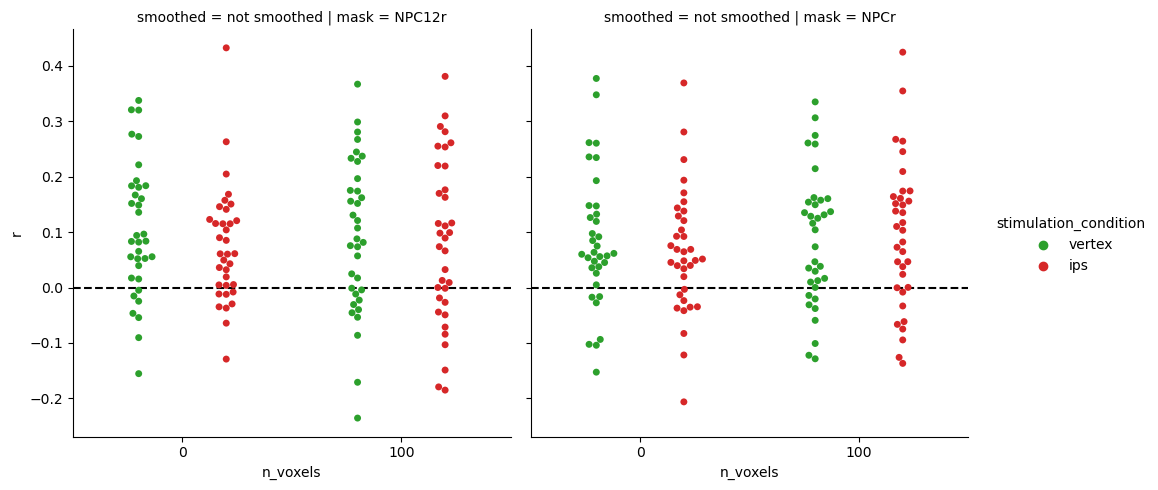

In [89]:
import seaborn as sns
g = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='swarm', row='smoothed', dodge=True, ci=67, palette=palette, hue_order=['vertex', 'ips']) 
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

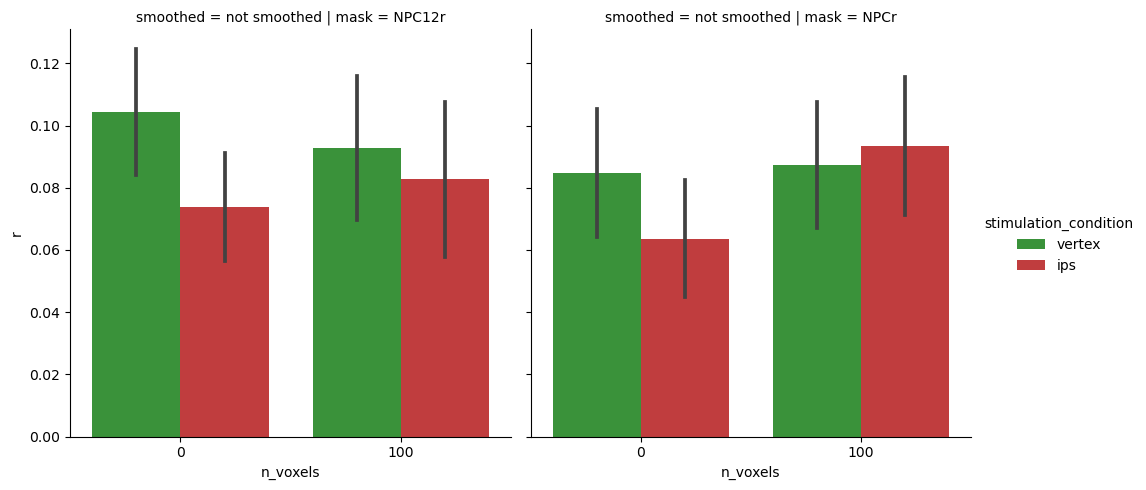

In [91]:
fac = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, errorbar='se', palette=palette, hue_order=['vertex', 'ips'])

In [92]:
r2.groupby(['n_voxels', 'mask']).apply(lambda d: pingouin.rm_anova(d.reset_index(), 'r', within='stimulation_condition', subject='subject'))

Source  ddof1  ddof2         F     p-unc  \
n_voxels mask                                                                
0        NPC12r 0  stimulation_condition      1     34  2.313410  0.137509   
         NPCr   0  stimulation_condition      1     34  0.897705  0.350084   
100      NPC12r 0  stimulation_condition      1     34  0.162819  0.689101   
         NPCr   0  stimulation_condition      1     34  0.084364  0.773233   

                        ng2  eps  
n_voxels mask                     
0        NPC12r 0  0.018978  1.0  
         NPCr   0  0.008443  1.0  
100      NPC12r 0  0.001284  1.0  
         NPCr   0  0.000608  1.0

<Axes: xlabel='n_voxels-mask', ylabel='stimulation_condition-n_voxels-mask'>

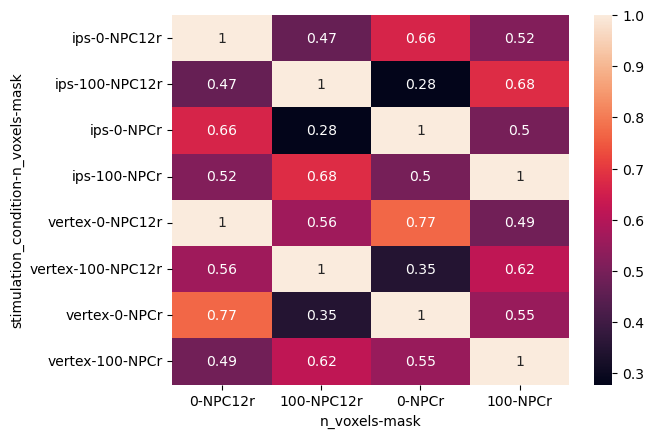

In [93]:
sns.heatmap(r2.droplevel('session').unstack(['n_voxels', 'mask'])['r'].droplevel(['pca', 'glm', 'smoothed']).groupby(['stimulation_condition']).corr(), annot=True)

In [94]:
import bambi

In [95]:
model = bambi.Model('r ~ stimulation_condition + (stimulation_condition|subject)', r2.xs('NPC12r', 0, 'mask').xs(0, 0, 'n_voxels').reset_index())
idata = model.fit(cores=1, target_accept=0.85, burnin=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7602, but should be close to 0.85. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6993, but should be close to 0.85. Try to increase the number of tuning steps.


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_65753/3283723301.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['stimulation_condition'])


<xarray.DataArray 'stimulation_condition' ()>
array(0.0715)

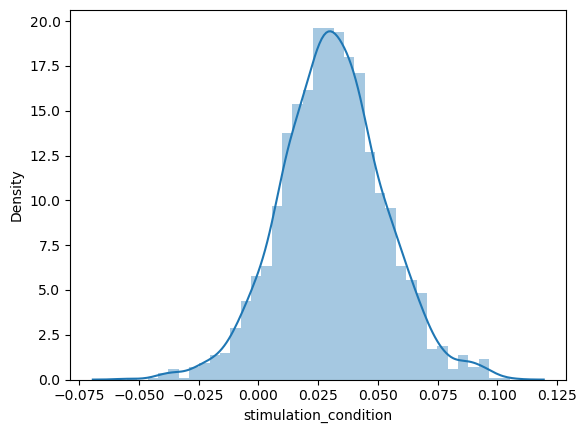

In [96]:
sns.distplot(idata.posterior['stimulation_condition'])

(idata.posterior['stimulation_condition'] < 0.0).mean()

In [100]:
model = bambi.Model('E ~ n1*stimulation_condition + (n1*stimulation_condition|subject)', pred.xs(0, 0, 'n_voxels').xs('NPC12r', 0, 'mask').reset_index() )
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, n1, stimulation_condition, n1:stimulation_condition, 1|subject_sigma, 1|subject_offset, n1|subject_sigma, n1|subject_offset, stimulation_condition|subject_sigma, stimulation_condition|subject_offset, n1:stimulation_condition|subject_sigma, n1:stimulation_condition|subject_offset, E_sigma]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'n1'}>, <Axes: title={'center': 'n1'}>],
       [<Axes: title={'center': 'stimulation_condition'}>,
        <Axes: title={'center': 'stimulation_condition'}>],
       [<Axes: title={'center': 'n1:stimulation_condition'}>,
        <Axes: title={'center': 'n1:stimulation_condition'}>],
       [<Axes: title={'center': '1|subject_sigma'}>,
        <Axes: title={'center': '1|subject_sigma'}>],
       [<Axes: title={'center': 'n1|subject_sigma'}>,
        <Axes: title={'center': 'n1|subject_sigma'}>],
       [<Axes: title={'center': 'stimulation_condition|subject_sigma'}>,
        <Axes: title={'center': 'stimulation_condition|subject_sigma'}>],
       [<Axes: title={'center': 'n1:stimulation_condition|subject_sigma'}>,
        <Axes: title={'center': 'n1:stimulation_condition|subject_sigma'}>],
       [<Axes: title={'center': 'E_sigma'}>,
        <Axes: title={'cent

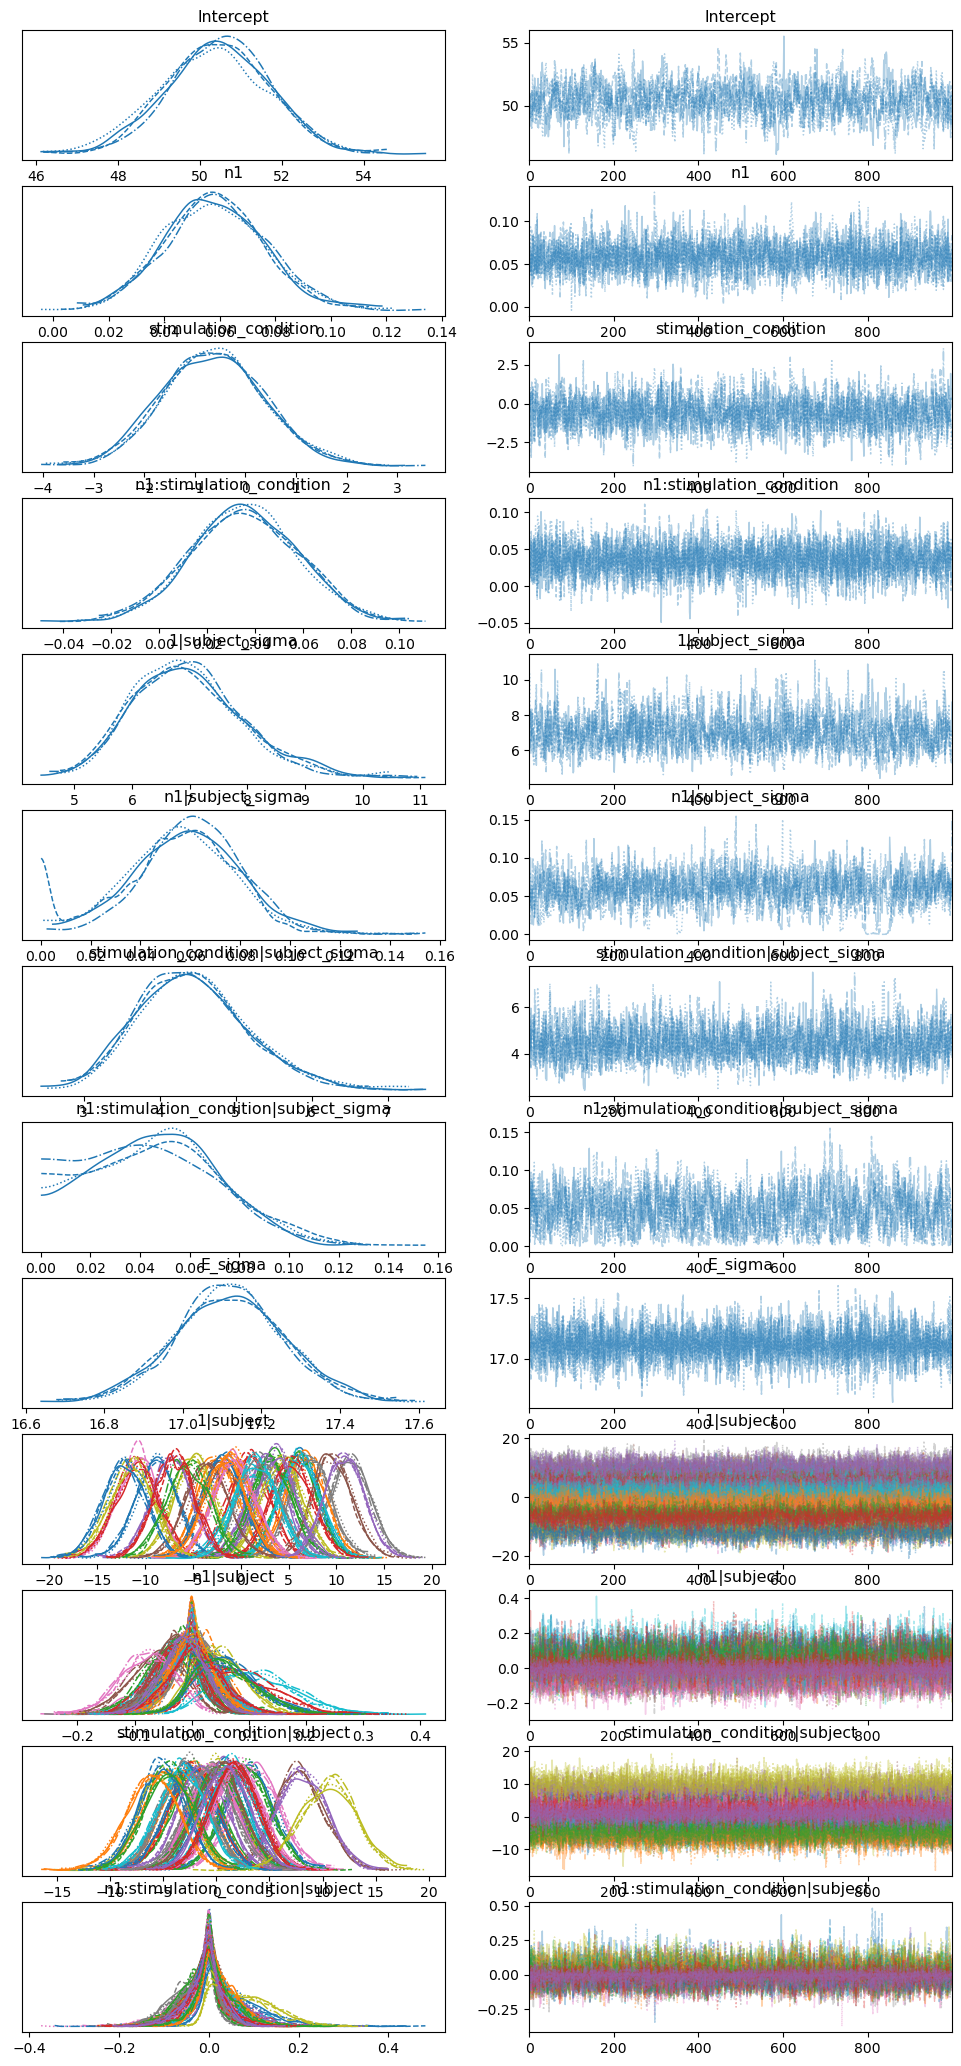

In [103]:
import arviz as az

az.plot_trace(idata)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_65753/1763309214.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['stimulation_condition'])


<Axes: xlabel='stimulation_condition', ylabel='Density'>

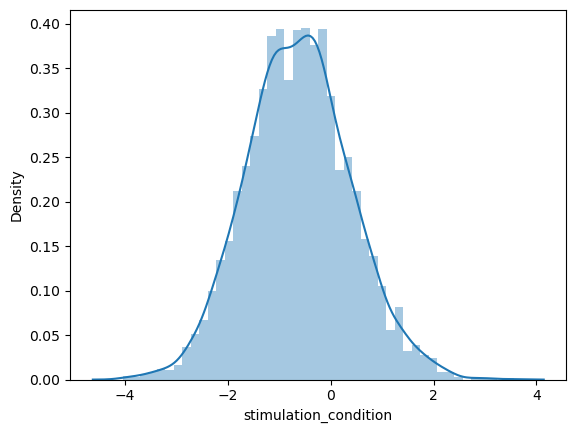

In [105]:
sns.distplot(idata.posterior['stimulation_condition'])

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_65753/3523066283.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['n1:stimulation_condition'])


<xarray.DataArray 'n1:stimulation_condition' ()>
array(0.05575)

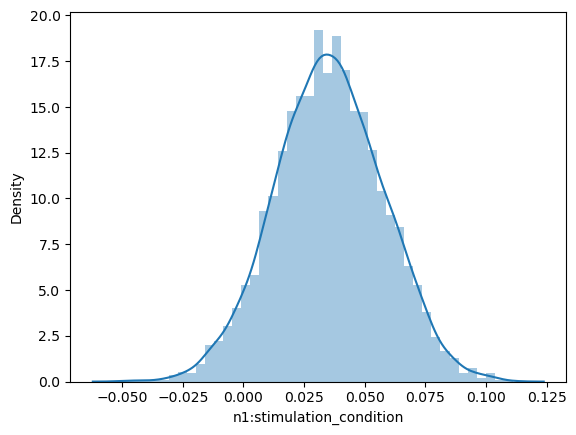

In [109]:
sns.distplot(idata.posterior['n1:stimulation_condition'])

(idata.posterior['n1:stimulation_condition'] < 0.0).mean()

In [112]:
model = bambi.Model('E ~ n1*stimulation_condition + (n1*stimulation_condition|subject)', pred.xs('NPCr', 0, 'mask').xs(0, 0, 'n_voxels').reset_index())
idata = model.fit(cores=1, target_accept=0.85, burnin=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 108 seconds.


In [111]:
sns.distplot(idata.posterior['n1:stimulation_condition'])

(idata.posterior['n1:stimulation_condition'] < 0.0).mean()

KeyError: 'n1:stimulation_condition'

In [35]:
pred['error'] = pred['E'] - pred['n1']

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_65753/2652208079.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(data=pred.groupby(['subject', 'n_voxels', 'stimulation_condition', 'risky_first']).mean().reset_index(), x='n_voxels', col='risky_first', hue='stimulation_condition', y='error', kind='point', errorbar='se',


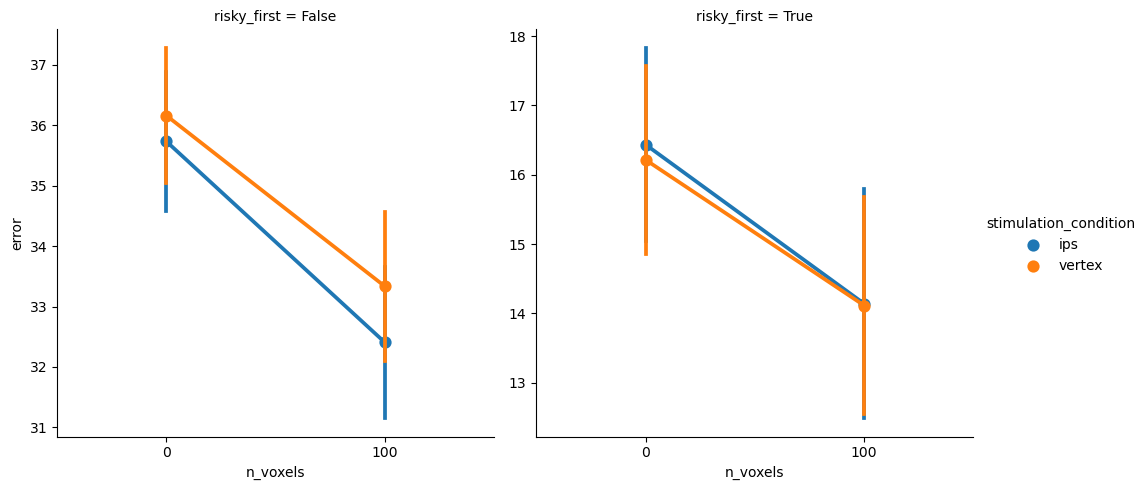

In [36]:
sns.catplot(data=pred.groupby(['subject', 'n_voxels', 'stimulation_condition', 'risky_first']).mean().reset_index(), x='n_voxels', col='risky_first', hue='stimulation_condition', y='error', kind='point', errorbar='se',
            sharey=False)

In [37]:
tmp = pred.groupby(['subject', 'n_voxels', 'stimulation_condition', 'risky_first']).mean().xs(100, 0, 'n_voxels')


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_65753/327191763.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pred.groupby(['subject', 'n_voxels', 'stimulation_condition', 'risky_first']).mean().xs(100, 0, 'n_voxels')


In [38]:
pred.groupby(['subject', 'session', 'n_voxels']).size().groupby(['n_voxels', 'session']).size()

n_voxels  session
0         2          35
          3          35
100       2          35
          3          35
dtype: int64

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_65753/1664714461.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pred.groupby(['subject', 'stimulation_condition', 'n_voxels']).mean()


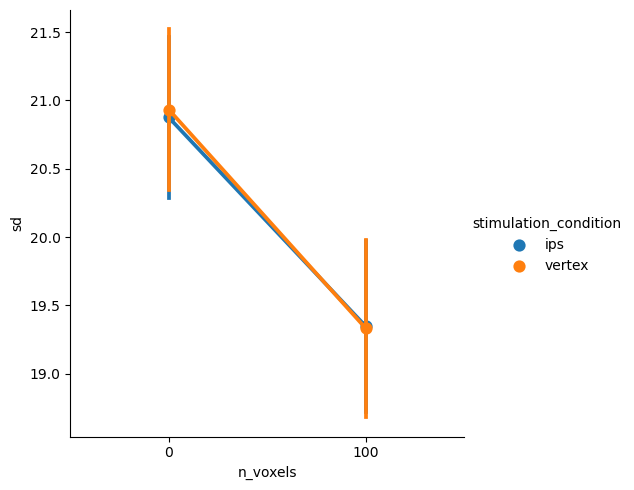

In [39]:
tmp = pred.groupby(['subject', 'stimulation_condition', 'n_voxels', 'mask']).mean()

sns.catplot(x='n_voxels', y='sd', hue='stimulation_condition', data=tmp.reset_index(), kind='point', errorbar='se', col='mask')